In [67]:
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


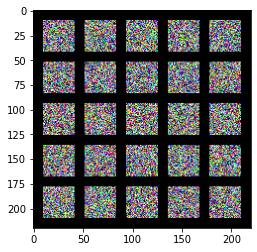

In [70]:
def get_random_img(batch_size, channel, height, weight):
    imgs = torch.randn(batch_size, channel, height, weight)
    return imgs
def show_tensor_images(image_tensor, num_images=25):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], padding = 10, nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()
imgs = get_random_img(128, 3, 32, 32)
show_tensor_images(imgs)

In [71]:
batch_size = 128
channel = 100
height = 1
weight = 1
imgs = get_random_img(batch_size, channel, height, weight)
print(imgs.shape)
#show_tensor_images(imgs)
transpose_conv = nn.ConvTranspose2d(channel, 1024, kernel_size = 4, stride = 1)
imgs_ = transpose_conv(imgs)
print(imgs_.shape)
#show_tensor_images(imgs_)

torch.Size([128, 100, 1, 1])
torch.Size([128, 1024, 4, 4])


In [72]:
class Generator(nn.Module):
    def __init__(self, z_dim, im_channel = 1, hidden_dim = 64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.get_generator_block(z_dim, hidden_dim * 4),
            self.get_generator_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.get_generator_block(hidden_dim * 2, hidden_dim),
            self.get_generator_block(hidden_dim, im_channel, kernel_size=4, final_layer=True),
        )
    def get_generator_block(self, input_channel, output_channel, kernel_size = 3, stride = 2, final_layer = False):
        
        
        if not final_layer:
            return nn.Sequential(
            nn.ConvTranspose2d(input_channel, output_channel, kernel_size = kernel_size, stride=stride),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace = True)
            )
        else:
            return nn.Sequential(
            nn.ConvTranspose2d(input_channel, output_channel, kernel_size = kernel_size, stride = stride),
            nn.Tanh()
            )
 
    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)
    def unsqueeze_noise(self, noise):
        
        return noise.view(len(noise), self.z_dim, 1, 1)
def get_noise(num_samples, z_dim, device = "cpu"):
    return torch.randn(num_samples, z_dim, device = device)

In [73]:
batch_size = 128
z_dim = 64
noise = get_noise(batch_size, z_dim, device)
print(noise.shape)
gen = Generator(z_dim, 1, 16).to(device)
noise = gen.unsqueeze_noise(noise)
model = gen.get_generator_block(z_dim, 16*4)
s = model(noise)
s.shape

torch.Size([128, 64])


torch.Size([128, 64, 3, 3])

torch.Size([128, 1, 28, 28])


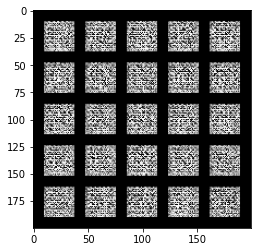

In [74]:
gen = Generator(64, 1, hidden_dim=64).to(device)
noise = get_noise(batch_size, z_dim = 64, device = device)
fake = gen(noise)
print(fake.shape)
show_tensor_images(fake)

In [75]:
class Discriminator(nn.Module):
    def __init__(self, im_channel = 1, hidden_dim = 16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.get_discriminator_block(im_channel, hidden_dim),
            self.get_discriminator_block(hidden_dim, hidden_dim * 2),
            self.get_discriminator_block(hidden_dim * 2, 1, final_layer=True),
        )
    def get_discriminator_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )
        else:
            return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )
    def forward(self, img):
        pred = self.disc(img)
        return pred.view(len(pred), -1)

In [76]:
img = get_random_img(batch_size = 128, channel = 1, height = 28, weight = 28)
disc = Discriminator(im_channel=1, hidden_dim=64)
disc_output = disc(img)
print(disc_output.shape)

torch.Size([128, 1])


In [77]:
def get_data(batch_size = 128):
    # You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
    dataloader = DataLoader(MNIST(".", download=True, transform=transform), batch_size = batch_size, shuffle=True)
    return dataloader

## Training

In [58]:
criterion = nn.BCEWithLogitsLoss()
batch_size = 128
lr = 0.0002
z_dim = 64
display_step = 500
beta1 = 0.5
beta2 = 0.999

dataloader = get_data(batch_size)


In [59]:
gen = Generator(z_dim=z_dim).to(device)
gen_opt = torch.optim.Adam(params = gen.parameters(), lr = lr, betas= (beta1, beta2))

disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(params= disc.parameters(), lr = lr, betas=(beta1, beta2))



In [60]:
isinstance(2, int) # verilen objenin class kontrolunu yapiyor

True

In [61]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
        torch.nn.init.constant_(m.bias, 0)
        

In [62]:
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)


In [63]:
for i in tqdm(range(1000)):
    pass

100%|█████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1001505.25it/s]


In [64]:
def get_disc_loss(gen, disc, real_imgs, z_dim, batch_size, criterion, get_noise = get_noise, device = "cpu"):
    
    
    noise = get_noise(batch_size, z_dim, device)
    fake = gen(noise)
    pred_fake = disc(fake.detach()) # burada disc tarafinda generator tarafi icin gradient degerlerini hesaplamak gereksiz
    target = torch.zeros_like(pred_fake)
    loss1 = criterion(pred_fake, target)
    
    pred_real = disc(real_imgs)
    target = torch.ones_like(pred_real)
    loss2 = criterion(pred_real, target)
    disc_loss = (loss1 + loss2) / 2
    return disc_loss

In [65]:
def get_gen_loss(gen, disc, z_dim, batch_size, criterion, get_noise = get_noise, device = "cpu"):
    
    noise = get_noise(batch_size, z_dim, device)
    fake = gen(noise)
    pred_fake = disc(fake)
    target = torch.ones_like(pred_fake)
    gen_loss = criterion(pred_fake, target)
    return gen_loss

In [78]:
curr_step = 1
n_epochs = 50
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    for imgs, labels in tqdm(dataloader):
        curr_batch_size = imgs.shape[0]
        imgs = imgs.to(device)
        
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, imgs, z_dim, curr_batch_size, criterion, get_noise, device)
        mean_discriminator_loss += disc_loss.item() / display_step
        disc_loss.backward(retain_graph = True)
        disc_opt.step()
        
        
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, z_dim, curr_batch_size, criterion, get_noise, device)
        mean_generator_loss += gen_loss.item() / display_step
        gen_loss.backward(retain_graph = True)
        gen_opt.step()
        
        if curr_step % display_step == 0 :
            print(f"Epoch {epoch}, step {curr_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            noise = get_noise(curr_batch_size, z_dim, device)
            fake = gen(noise)
            
            show_tensor_images(fake)
            show_tensor_images(imgs)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
            

  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 